In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/纯苯.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['纯苯华东市场价'].last_valid_index()   

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,纯苯华东市场价,Brent原油期货连1合约价格/路透,人民币汇率收盘价,纯苯-Brent价差
2025-12-02,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN
2025-12-08,NaN,NaN,NaN,NaN


In [5]:
sheet2 = pd.ExcelFile('eta/纯苯-Brent价差_合并数据.xlsx').parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2 = sheet2.drop(columns=['纯苯-Brent价差'])
sheet2 = sheet2.dropna()
sheet2.head()

,Date,纯苯-Brent价差_预测
17,2025-11-08,1573.51080
16,2025-11-10,2145.58275
15,2025-11-11,2235.47310
14,2025-11-12,2088.66345
13,2025-11-13,2005.15380


In [6]:
# 尝试多个可能的文件路径
file_paths3 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/Brent原油价格_合并数据.xlsx")
]

file_path3 = None
for path3 in file_paths3:
    if os.path.isfile(path3):  # 确保是文件而不是目录
        file_path3 = path3
        break

if file_path3 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet3 = pd.read_excel(file_path3, sheet_name='Sheet1')
    sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
    sheet3 = sheet3.drop(columns=['布伦特原油期货价格'])
    sheet3 = sheet3.dropna()
    sheet3 = sheet3.sort_values('Date', ascending=True)
    sheet3.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet3.head()

,Date,Brent原油期货价格预测
20,2025-11-10,63.98
19,2025-11-11,64.92
18,2025-11-12,64.85
17,2025-11-13,64.98
16,2025-11-14,64.20


In [7]:
# 尝试多个可能的文件路径
file_paths4 = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/USDCNY即期汇率_合并数据.xlsx")
]

file_path4 = None
for path4 in file_paths4:
    if os.path.isfile(path4):  # 确保是文件而不是目录
        file_path4 = path4
        break

if file_path4 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet4 = pd.read_excel(file_path4, sheet_name='Sheet1')
    sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
    sheet4 = sheet4.drop(columns=['真实值'])
    sheet4 = sheet4.dropna()
    sheet4 = sheet4.sort_values('Date', ascending=True)
    sheet4.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet4.head()

,Date,预测值
19,2025-11-10,7.1252
18,2025-11-11,7.1325
17,2025-11-12,7.1325
16,2025-11-13,7.1383
15,2025-11-14,7.1384


In [8]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据


sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '纯苯-Brent价差_预测']],
    on='Date',
    how='left'
)
sheet_daily['纯苯-Brent价差'] = sheet_daily['纯苯-Brent价差'].fillna(sheet_daily['纯苯-Brent价差_预测'])
sheet_daily = sheet_daily.drop(columns=['纯苯-Brent价差_预测'])


sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', 'Brent原油期货价格预测']],
    on='Date',
    how='left'
)
sheet_daily['Brent原油期货连1合约价格/路透'] = sheet_daily['Brent原油期货连1合约价格/路透'].fillna(sheet_daily['Brent原油期货价格预测'])
sheet_daily = sheet_daily.drop(columns=['Brent原油期货价格预测'])


sheet_daily = pd.merge(
    sheet_daily,
    sheet4[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['人民币汇率收盘价'] = sheet_daily['人民币汇率收盘价'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
sheet_daily.tail()

,Date,纯苯华东市场价,Brent原油期货连1合约价格/路透,人民币汇率收盘价,纯苯-Brent价差
8680,2025-12-02,NaN,66.09,7.1318,2282.035098
8681,2025-12-03,NaN,66.69,7.1246,NaN
8682,2025-12-04,NaN,66.63,7.1246,NaN
8683,2025-12-05,NaN,65.18,7.1244,NaN
8684,2025-12-08,NaN,NaN,NaN,NaN


In [9]:
# 添加新列 山东汽油裂解差_预测
sheet_daily['纯苯华东市场价_预测'] =  sheet_daily['纯苯-Brent价差'] + ( sheet_daily['Brent原油期货连1合约价格/路透'] * 1.13 * sheet_daily['人民币汇率收盘价'] * 7.33)
sheet_daily.tail()

,Date,纯苯华东市场价,Brent原油期货连1合约价格/路透,人民币汇率收盘价,纯苯-Brent价差,纯苯华东市场价_预测
8680,2025-12-02,NaN,66.09,7.1318,2282.035098,6186.102667
8681,2025-12-03,NaN,66.69,7.1246,NaN,NaN
8682,2025-12-04,NaN,66.63,7.1246,NaN,NaN
8683,2025-12-05,NaN,65.18,7.1244,NaN,NaN
8684,2025-12-08,NaN,NaN,NaN,NaN,NaN


---

In [10]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '纯苯华东市场价']]
historical.columns = ['Date', '纯苯华东市场价']
# 只保留2024年1月1日之后的数据
historical = historical[historical['Date'] >= '2024-01-01']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '纯苯华东市场价_预测']]
forecast.columns = ['Date', '纯苯华东市场价_预测']



# 获取最后一个有主焦煤价格/临汾值的行
last_price_row = historical.iloc[-1]
last_price_date = pd.to_datetime(last_price_row['Date'])
last_price = last_price_row['纯苯华东市场价']
# 创建新行,日期为最后一个有值日期的后一天
new_row = pd.DataFrame({
    'Date': [last_price_date + pd.Timedelta(days=1)],
    '纯苯华东市场价': [np.nan],
    '纯苯华东市场价_预测': [last_price]
})
# 将新行添加到forecast中
forecast = pd.concat([new_row, forecast])




# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 删除纯苯华东市场价和纯苯华东市场价_预测都为nan的行
merged_df_daily = merged_df_daily.dropna(subset=['纯苯华东市场价', '纯苯华东市场价_预测'], how='all')
merged_df_daily.to_excel('eta/纯苯_合并数据.xlsx', index=False,float_format='%.6f')   
merged_df_daily.head()

,Date,纯苯华东市场价,纯苯华东市场价_预测
518,2025/12/02,NaN,6186.102667
517,2025/12/01,NaN,6151.366549
516,2025/11/28,NaN,6166.749940
515,2025/11/27,NaN,6047.126847
514,2025/11/26,NaN,6117.836545


In [11]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '纯苯华东市场价']]
historical_monthly.columns = ['Date', '纯苯华东市场价']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '纯苯华东市场价_预测']]
forecast_monthly.columns = ['Date', '纯苯华东市场价_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly = merged_df_monthly.dropna(subset=['纯苯华东市场价', '纯苯华东市场价_预测'], how='all')
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/纯苯_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly.head()

,Date,纯苯华东市场价,纯苯华东市场价_预测
405,2025/12/31,NaN,6168.734608
404,2025/11/30,5357.000000,5800.126723
403,2025/10/31,5554.722222,5548.235296
402,2025/09/30,5896.521739,5897.272727
401,2025/08/31,6077.380952,6077.380946


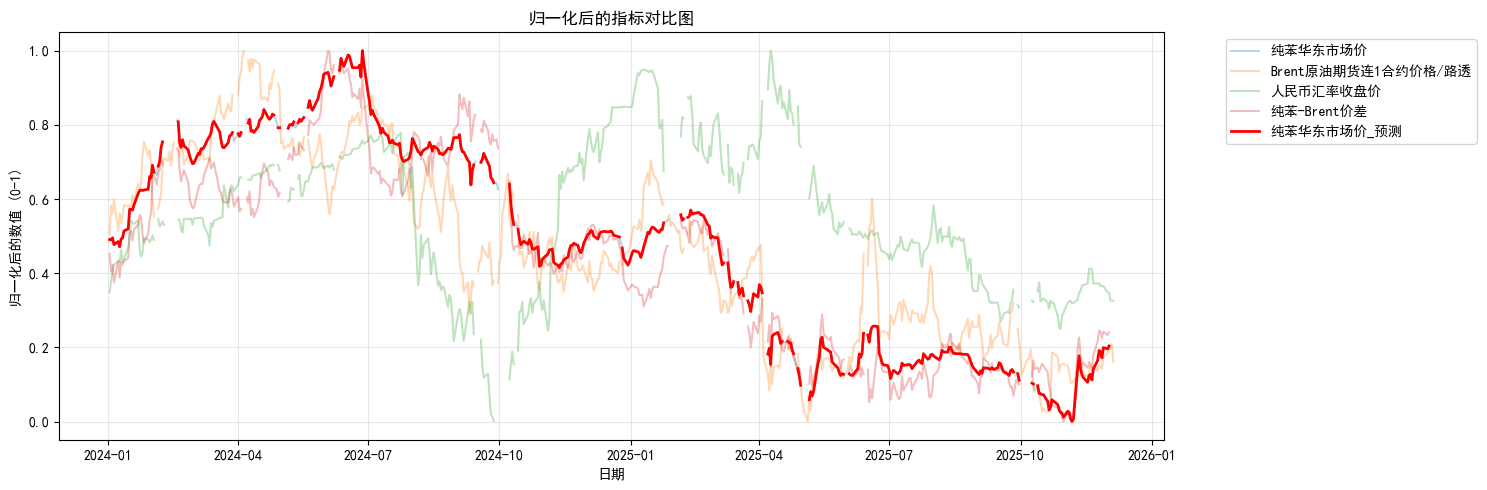

In [12]:
# 对数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler

# 创建一个新的DataFrame来存储归一化后的数据
normalized_df = sheet_daily.copy()
normalized_df1 = sheet_daily.copy()
# 筛选2024年及以后的数据
normalized_df = normalized_df[normalized_df['Date'] >= '2024-01-01'].copy()
normalized_df1 = normalized_df1[normalized_df1['Date'] >= '2024-01-01'].copy()
# 对每一列进行归一化处理(除了Date列)
scaler = MinMaxScaler()
columns_to_normalize = [col for col in sheet_daily.columns if col != 'Date']
normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df1[columns_to_normalize])


# 绘制归一化后的数据
plt.figure(figsize=(15, 5))

# 设置透明度
alpha_others = 0.3  
alpha_main = 1.0    

# 绘制每个指标
for col in normalized_df.columns:
    if col != 'Date':  
        if col == '纯苯华东市场价_预测':
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    color='red', 
                    linewidth=2,
                    alpha=alpha_main)
        else:
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    alpha=alpha_others)

plt.title('归一化后的指标对比图')
plt.xlabel('日期')
plt.ylabel('归一化后的数值 (0-1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



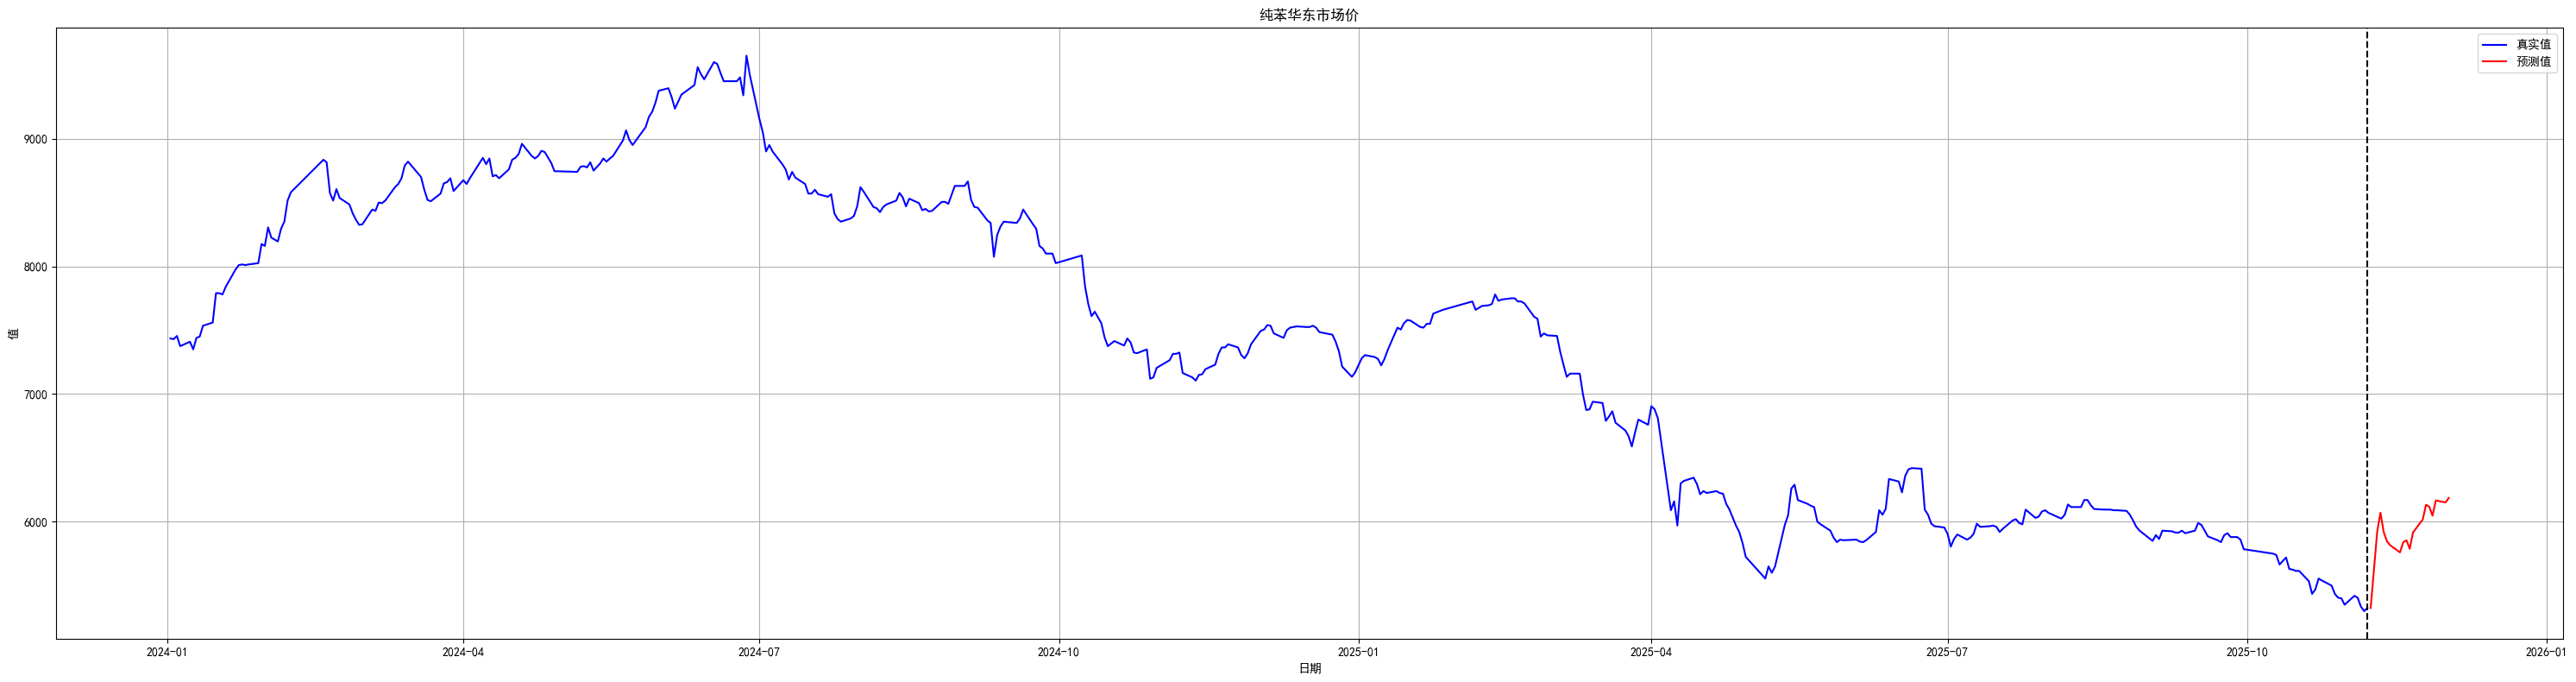

In [13]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
# 筛选2024年之后的数据
merged_df_daily_plot = merged_df_daily_plot[merged_df_daily_plot['Date'] >= '2024-01-01']

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['纯苯华东市场价'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['纯苯华东市场价_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('纯苯华东市场价')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "纯苯华东市场价"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "纯苯华东市场价"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
